**U-Net: Convolutional Networks for Biomedical Image Segmentation**: *Olaf Ronneberger, Philipp Fischer, and Thomas Brox*

`DOI: 10.48550/arXiv.1505.04597`


---

ML Course Project

Group members: Igor Marchenko, Wangyiyao Zhou, Youyang Cai

## Importing modules


In [1]:
import os
import imageio
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Splitting the data

In [3]:


path = '/content/drive/My Drive/machine_project_data/'
ip = os.path.join(path, 'CameraRGB/')
mp = os.path.join(path, 'CameraMask/')
im_list = os.listdir(ip)
images, masks = [ip+i for i in im_list], [mp+i for i in im_list]

(-0.5, 639.5, 479.5, -0.5)

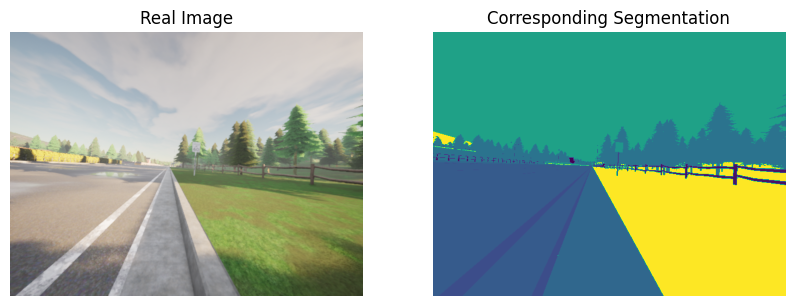

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(imageio.v2.imread(images[7]))
ax[1].imshow(imageio.v2.imread(masks[7])[:, :, 0])

ax[0].set_title('Real Image')
ax[1].set_title('Corresponding Segmentation')

ax[0].axis('off')
ax[1].axis('off')

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((tf.constant(images), tf.constant(masks)))

## Preprocessing stage

We have to resize the images, so that we don't run out of memory.

In [6]:
HEIGHT = 96
WIDTH = 128

In [7]:
def process_path(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return image, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (HEIGHT, WIDTH), method='nearest')
    input_mask = tf.image.resize(mask, (HEIGHT, WIDTH), method='nearest')
    return input_image, input_mask

def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Real Image', 'Real Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.show()

In [8]:
image_ds = dataset.map(process_path)
rescaled_ds = image_ds.map(preprocess)

Original dimensions: (480, 640, 1)


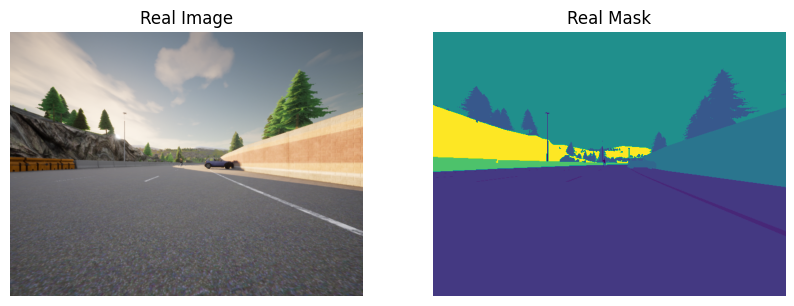

Dimensions after reshaping: (96, 128, 1)


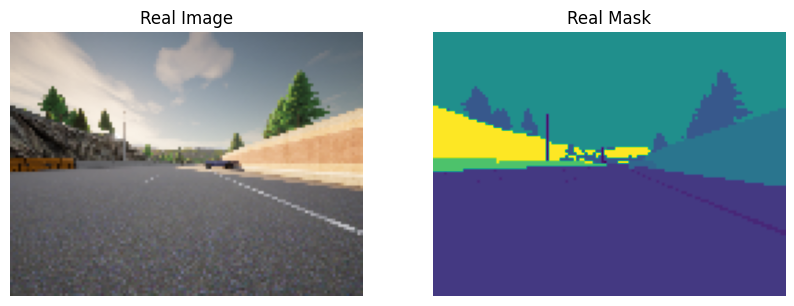

In [9]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print('Original dimensions: {}'.format(mask.shape))
display([sample_image, sample_mask])

for image, mask in rescaled_ds.take(1):
    sample_image, sample_mask = image, mask
    print('Dimensions after reshaping: {}'.format(mask.shape))
display([sample_image, sample_mask])

## Defining the model

In [10]:
class UNet:
    """
    Initializing the model
        input_size: shape of the input
        n_filters: base number of filters for the convolutional layers
        n_classes: number of output classes
    """
    def __init__(self, input_shape, n_filters, n_classes):
        self.input_shape = input_shape
        self.n_filters = n_filters
        self.n_classes = n_classes

        inputs = Input(self.input_shape)

        # Encoding (Contracting)
        en_1 = self._downsample(inputs=inputs,        multiplier=1,  dropout=0,   max_pooling=True)
        en_2 = self._downsample(inputs=en_1[0],       multiplier=2,  dropout=0,   max_pooling=True)
        en_3 = self._downsample(inputs=en_2[0],       multiplier=4,  dropout=0,   max_pooling=True)
        en_4 = self._downsample(inputs=en_3[0],       multiplier=8,  dropout=0,   max_pooling=True)
        en_5 = self._downsample(inputs=en_4[0],       multiplier=16, dropout=0.3, max_pooling=True)
        bottleneck = self._downsample(inputs=en_5[0], multiplier=32, dropout=0.3, max_pooling=False)

        # Decoding (Expanding)
        de_6 =  self._upsample(bottleneck[0], en_5[1], multiplier=16)
        de_7 =  self._upsample(de_6,          en_4[1], multiplier=8)
        de_8 =  self._upsample(de_7,          en_3[1], multiplier=4)
        de_9 =  self._upsample(de_8,          en_2[1], multiplier=2)
        de_10 = self._upsample(de_9,          en_1[1], multiplier=1)

        conv_10 = Conv2D(self.n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(de_10)
        conv_11 = Conv2D(self.n_classes, 1, activation='softmax', padding='same')(conv_10)

        self.model = tf.keras.Model(inputs=inputs, outputs=conv_11)

    """
    Convolutional downsampling used in contraction path
        inputs: input tensor
        n_filters: base number of filters for the convolutional layers
        dropout: dropout probability (if any)
        max_pooling: using MaxPooling to reduce the dimensions of the output
        next_layer, skip_connection: outputs of next layer and skip connection
    """
    def _downsample(self, inputs, multiplier, dropout, max_pooling):
        n_filters = self.n_filters * multiplier
        conv = Conv2D(n_filters, 3, activation='relu', padding="same", kernel_initializer='he_normal')(inputs)
        conv = Conv2D(n_filters, 3, activation='relu', padding="same", kernel_initializer='he_normal')(conv)

        if dropout > 0: conv = Dropout(dropout)(conv)
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv) if max_pooling else conv

        skip_connection = conv
        return next_layer, skip_connection

    """
    Convolutional upsampling used in expanding path
        expansive_input: input tensor from previous layer
        contractive_input: Input tensor from previous skip layer
        n_filters: base number of filters for the convolutional layers
        conv: output
    """
    def _upsample(self, expansive_input, contractive_input, multiplier):
        n_filters = self.n_filters * multiplier
        up = Conv2DTranspose(n_filters, 3, strides=(2, 2), padding='same')(expansive_input)

        # Merging the previous output and the contractive_input
        merge = concatenate([up, contractive_input], axis=3)
        conv = Conv2D(n_filters, 3, activation='relu', padding="same", kernel_initializer='he_normal')(merge)
        conv = Conv2D(n_filters, 3, activation='relu', padding="same", kernel_initializer='he_normal')(conv)

        return conv

    def build(self):
        return self.model

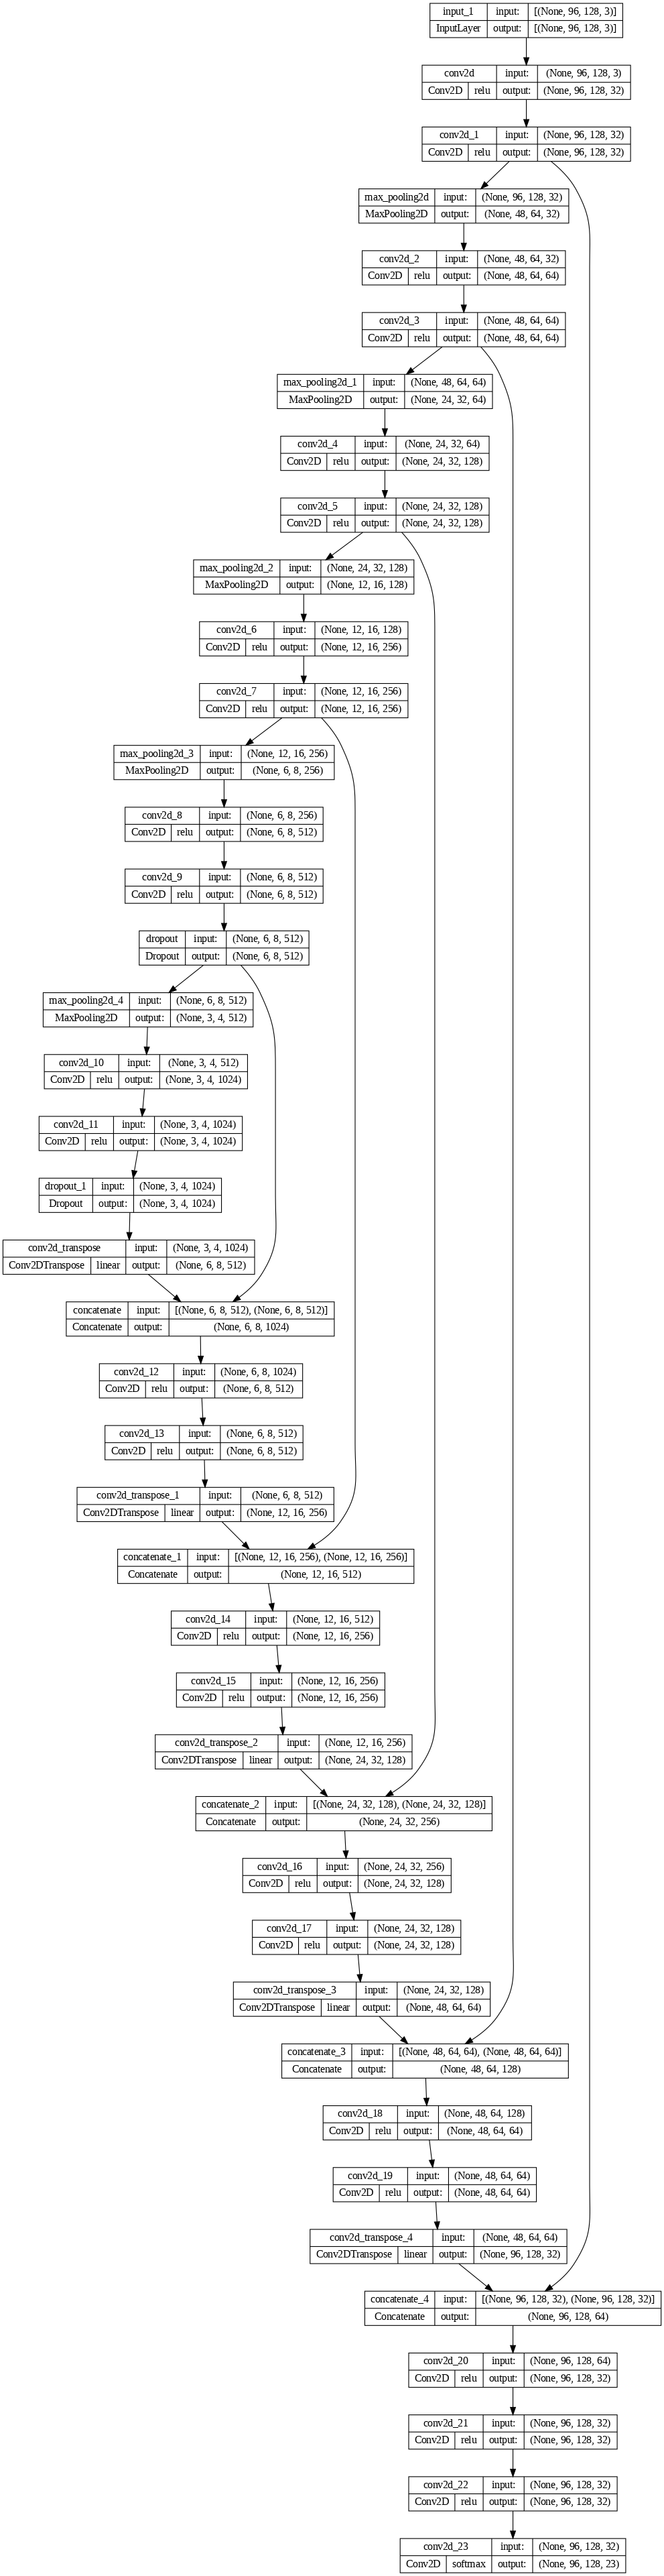

In [11]:
unet = UNet(input_shape=(HEIGHT, WIDTH, 3), n_filters=32, n_classes=23).build()
plot_model(unet, show_shapes=True, dpi=80, show_layer_activations=True, show_layer_names=True)

## Defining loss function

In [12]:
unet.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

## Training

In [13]:
train_ds = rescaled_ds.cache().shuffle(500).batch(32)
history = unet.fit(train_ds, epochs=40)

Epoch 1/40
33/33 [==============================] - 167s 2s/step - loss: 1.8983 - accuracy: 0.4535
Epoch 2/40
33/33 [==============================] - 7s 204ms/step - loss: 1.0253 - accuracy: 0.7220
Epoch 3/40
33/33 [==============================] - 7s 204ms/step - loss: 0.6605 - accuracy: 0.8217
Epoch 4/40
33/33 [==============================] - 7s 207ms/step - loss: 0.5077 - accuracy: 0.8538
Epoch 5/40
33/33 [==============================] - 7s 208ms/step - loss: 0.4039 - accuracy: 0.8805
Epoch 6/40
33/33 [==============================] - 7s 208ms/step - loss: 0.3452 - accuracy: 0.8961
Epoch 7/40
33/33 [==============================] - 7s 211ms/step - loss: 0.3009 - accuracy: 0.9092
Epoch 8/40
33/33 [==============================] - 7s 213ms/step - loss: 0.2606 - accuracy: 0.9212
Epoch 9/40
33/33 [==============================] - 7s 213ms/step - loss: 0.2272 - accuracy: 0.9314
Epoch 10/40
33/33 [==============================] - 7s 215ms/step - loss: 0.2125 - accuracy: 0.9359


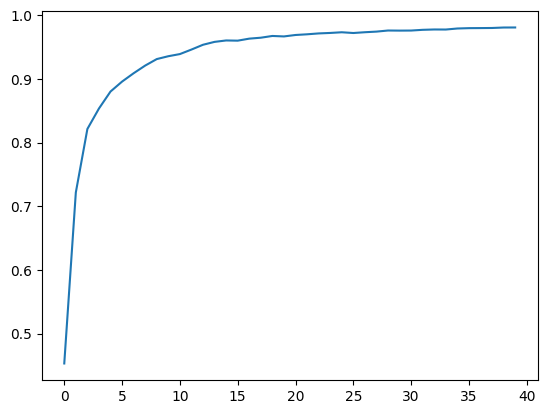

In [14]:
plt.plot(history.history["accuracy"])

## Extracting predictions

In [15]:
def extract_mask(pred_mask):
    return tf.argmax(pred_mask, axis=-1)[..., tf.newaxis][0]

## Predictions

In [16]:
def predict(dataset, num):
    for image, mask in dataset.take(num):
        pred_mask = unet.predict(image)
        display([image[0], mask[0], extract_mask(pred_mask)])

1/1 [==============================] - 0s 466ms/step


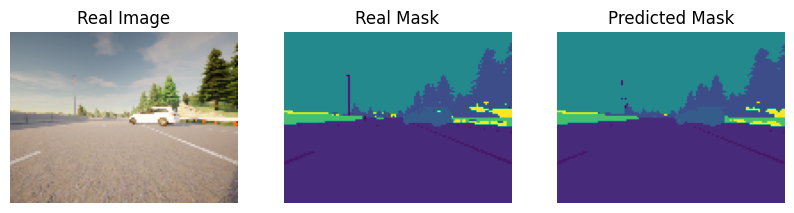

1/1 [==============================] - 0s 26ms/step


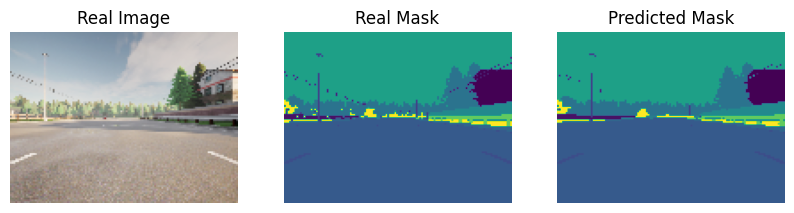

1/1 [==============================] - 0s 22ms/step


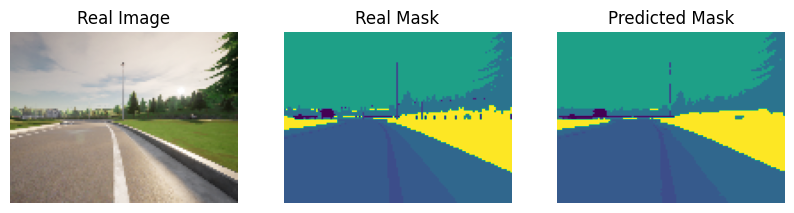

1/1 [==============================] - 0s 21ms/step


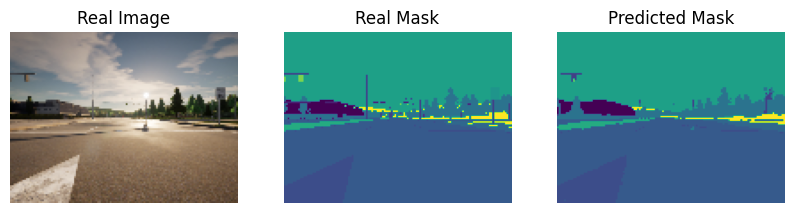

1/1 [==============================] - 0s 23ms/step


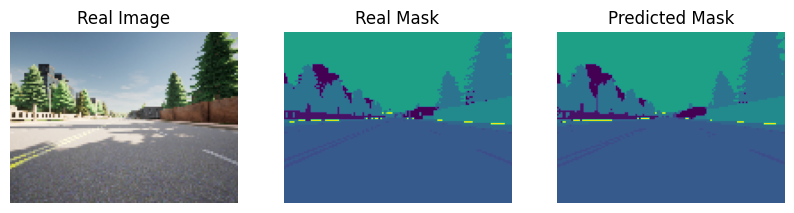

In [17]:
predict(train_ds, 5)